In [ ]:
! pip install -U -q transformers
! pip install -q datasets sentence-transformers evaluate
! pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e684c48bfd49ff8f43af30c98e2bec954cf55dadd34e5a0d4edf38c9341b2a72
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import re
from tqdm import notebook
import json

import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import r2_score

from datasets import Dataset
import evaluate

from sentence_transformers import SentenceTransformer, models, util

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

## Setting random seeed.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
SEED = 97
seed_everything(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


# Dataset load and process.

1. Load selected dataset for variability analysis.
2. Split into train, test and val sets.
3. Get sentence embeddings for each train sample (try sampling for each label separately).

Task - write a method for loading the dataset

In [ ]:
# def get_sst2_dataset_dfs(test_size=0.1):
#   dataset = load_dataset('sst2', 'binary')
#   train_df = dataset['train'].to_pandas().dropna()[['sentence', 'label']]
#   test_df = dataset['test'].to_pandas().dropna()[['sentence', 'label']]
#   val_df = dataset['validation'].to_pandas().dropna()[['sentence', 'label']]

#   return train_df, val_df, test_df

def get_sst2_dataset_dfs(test_size=0.1):
  dataset = load_dataset('sst2', 'binary')
  df = dataset['train'].to_pandas().dropna()

  X_train, X_temp, y_train, y_temp = train_test_split(df[['idx', 'sentence']], df.label, test_size=test_size*2, random_state=SEED, stratify=df.label)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

  train_df = X_train[['sentence']].copy().reset_index(drop=True)
  val_df = X_val[['sentence']].copy().reset_index(drop=True)
  test_df = X_test[['sentence']].copy().reset_index(drop=True)

  train_df['label'] = y_train.tolist()
  val_df['label'] = y_val.tolist()
  test_df['label'] = y_test.tolist()

  return train_df, val_df, test_df

In [ ]:
def get_imdb_dataset_dfs():
  dataset = load_dataset('imdb')
  train_df = dataset['train'].to_pandas().dropna()
  train_df.columns = ['sentence', 'label']

  test_df = dataset['test'].to_pandas().dropna()
  test_df.columns = ['sentence', 'label']

  return train_df, test_df

In [ ]:
def get_tweet_eval_dfs():
  dataset = load_dataset('tweet_eval', 'sentiment')
  train_df = dataset['train'].to_pandas().dropna()
  val_df = dataset['validation'].to_pandas().dropna()
  test_df = dataset['test'].to_pandas().dropna()

  train_df.columns = ['sentence', 'label']
  val_df.columns = ['sentence', 'label']
  test_df.columns = ['sentence', 'label']

  train_df = train_df[train_df.label != 2].reset_index(drop=True)
  val_df = val_df[val_df.label != 2].reset_index(drop=True)
  test_df = test_df[test_df.label != 2].reset_index(drop=True)

  return train_df, val_df, test_df

# Load Embeddings model

In [ ]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
def get_embeddings(data):
    return embedder.encode(data, convert_to_tensor=True)

# Variance Utilities

In [ ]:
# embeddings -> (25000, 384) -> (25000, 100)
def get_self_variance(embeddings, n_components=100):
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(embeddings)

  # how much of the variance or information you were able to retain

  explained_variance_ratio = pca.explained_variance_ratio_
  # explained_variance_ratio = size -> (100, ) # sorted in descending order
  return np.sum(explained_variance_ratio), explained_variance_ratio

In [ ]:
# embeddings -> (25000, 384)
def get_variance_measures(embeddings, step=10, n_components=100):
  rng = np.random.default_rng()

  r2_values = []
  self_exp_vars = []
  subset_sizes = []
  rand_subsets_indices = []
  indices = np.arange(embeddings.shape[0])

  step_size = len(embeddings)//step

  for n in notebook.tqdm(range(step_size, len(embeddings)+1, step_size)):
    subset_sizes.append(n)
    pca = PCA(n_components=n_components)

    subset_indices = rng.choice(indices, n, replace=False)
    rand_subsets_indices.append(subset_indices)

    # 1st iteration -> (2500, 384) pca on the subset
    principal_components = pca.fit_transform(embeddings[subset_indices])

    explained_variance_ratio = pca.explained_variance_ratio_

    expl_var = np.sum(explained_variance_ratio)
    self_exp_vars.append(expl_var)

    # pca.transform(embeddings) -> (25000, 100)
    # pca.inverse_transform(pca.transform(embeddings)) - (25000, 100) -> (25000, 384)

    r2_values.append(r2_score(embeddings, pca.inverse_transform(pca.transform(embeddings)), multioutput='variance_weighted'))

  return self_exp_vars, r2_values, subset_sizes, rand_subsets_indices

In [ ]:
def plot_variance_measure(subset_sizes, r2_values, full_set_var):
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

In [ ]:
def plot_variance_measure_extra(subset_sizes, r2_values, full_set_var, self_expl_vars):
  r2_values.insert(0, 0)
  subset_sizes.insert(0, 0)
  graph = sns.lineplot(x=subset_sizes, y=r2_values, marker="o")
  sns.lineplot(x=subset_sizes, y=self_expl_vars, marker="o")
  graph.axhline(full_set_var, color='red')
  plt.show()

# Variance Analysis

## Tweet Eval

In [ ]:
train_df_te, val_df_te, test_df_te = get_tweet_eval_dfs()

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
sentence_embeddings_te = get_embeddings(train_df_te['sentence'].values).detach().cpu().numpy()

In [ ]:
train_df_te.label.value_counts()

1    20673
0     7093
Name: label, dtype: int64

In [ ]:
val_df_te.label.value_counts()

1    869
0    312
Name: label, dtype: int64

In [ ]:
test_df_te.label.value_counts()

1    5937
0    3972
Name: label, dtype: int64

  0%|          | 0/10 [00:00<?, ?it/s]

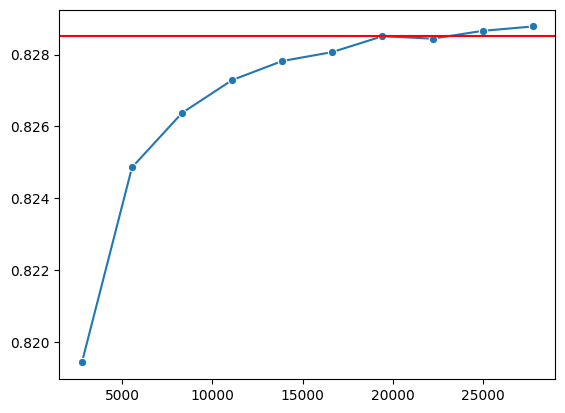

In [ ]:
full_set_var_te, explained_variance_ratio_te = get_self_variance(sentence_embeddings_te)
self_expl_vars_te, r2_values_te, subset_sizes_te, rand_subset_indices_te = get_variance_measures(sentence_embeddings_te)
plot_variance_measure(subset_sizes_te, r2_values_te, full_set_var_te)

## SST2

In [ ]:
train_df_sst, val_df_sst, test_df_sst = get_sst2_dataset_dfs()

In [ ]:
# convert sentences to vectors of size 384
sentence_embeddings_sst = get_embeddings(train_df_sst['sentence'].values).detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

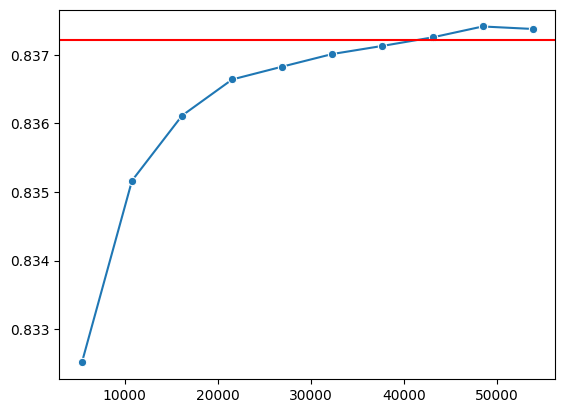

In [ ]:
full_set_var_sst, explained_variance_ratio_sst = get_self_variance(sentence_embeddings_sst)
self_expl_vars_sst, r2_values_sst, subset_sizes_sst, rand_subset_indices_sst = get_variance_measures(sentence_embeddings_sst)
plot_variance_measure(subset_sizes_sst, r2_values_sst, full_set_var_sst)

## IMDB

In [ ]:
train_df_imdb, test_df_imdb = get_imdb_dataset_dfs()

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
sentence_embeddings_imdb = get_embeddings(train_df_imdb['sentence'].values).detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

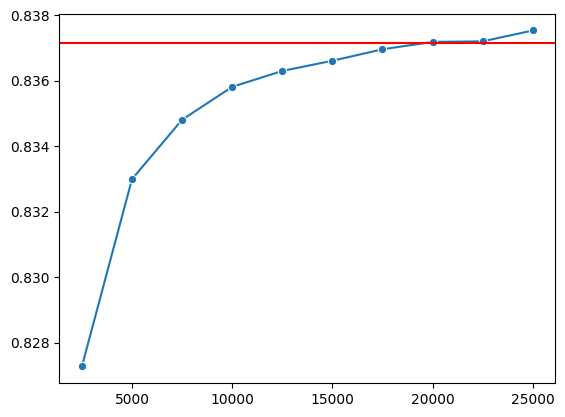

In [ ]:
full_set_var_imdb, explained_variance_ratio_imdb = get_self_variance(sentence_embeddings_imdb)
self_expl_vars_imdb, r2_values_imdb, subset_sizes_imdb, rand_subset_indices_imdb = get_variance_measures(sentence_embeddings_imdb)
plot_variance_measure(subset_sizes_imdb, r2_values_imdb, full_set_var_imdb)

In [ ]:
subset_sizes_imdb

[2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

# Modelling

In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
SAVE_MODEL_PATH = "/content/drive/MyDrive/Representative Subset/Models"
SAVE_LOGS_PATH = "/content/drive/MyDrive/Representative Subset/Logs"
LEARNING_RATE = 5e-5
EPOCHS = 3

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["sentence"],
                     max_length=MAX_LEN,
                     truncation=True,
                     padding="max_length"
                     )

In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Define model
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [ ]:
def get_hf_dataset(df):
  data = Dataset.from_pandas(df)
  dataset = data.map(tokenize_dataset)
  return dataset

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir=SAVE_MODEL_PATH,
    logging_dir=SAVE_LOGS_PATH,
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
DATASET_NAME = "Tweet_Eval"

In [ ]:
def train_on_subsets(subset_sizes, subset_indices_list, train_df, test_df, val_df=None):

  sizes = []
  test_accuracies = []
  test_losses = []

  test_dataset = get_hf_dataset(test_df)
  if val_df is not None:
    val_dataset = get_hf_dataset(val_df)
  else:
    val_dataset = get_hf_dataset(test_df.copy())

  for i in range(7, len(subset_sizes)):
    subset_indices = subset_indices_list[i]
    subset_train_df = train_df.loc[subset_indices].reset_index(drop=True)
    subset_train_df.columns = ['sentence', 'label']

    train_dataset = get_hf_dataset(subset_train_df)
    print(subset_train_df.label.value_counts())

    trainer = Trainer(
      model_init=model_init,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    test_predict_result = trainer.predict(test_dataset)

    test_accuracies.append(test_predict_result.metrics['test_accuracy'])
    test_losses.append(test_predict_result.metrics['test_loss'])

    print(f"For subset: {subset_sizes[i]} -> Test Accuracy: {test_predict_result.metrics['test_accuracy']}, Test Loss: {test_predict_result.metrics['test_loss']}\n")

    sizes.append(subset_sizes[i])
    trainer.save_model(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/Subset-Models/model-{subset_sizes[i]}")

  return sizes, test_accuracies, test_losses

In [ ]:
def plot_stats(subset_sizes, test_accuracies, test_losses):
  sns.lineplot(x=subset_sizes, y=test_accuracies, marker="o")
  plt.show()

In [ ]:
sizes, test_accuracies, test_losses = train_on_subsets(subset_sizes_te, rand_subset_indices_te, train_df_te, test_df_te, val_df_te)

Map:   0%|          | 0/9909 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/22208 [00:00<?, ? examples/s]

1    16537
0     5671
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.392000,0.380871,0.817104
2,0.234400,0.401367,0.823878


For subset: 22208 -> Test Accuracy: 0.7604198203653244, Test Loss: 0.4855095446109772



Map:   0%|          | 0/24984 [00:00<?, ? examples/s]

1    18643
0     6341
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.391500,0.390544,0.792549
2,0.230600,0.446341,0.807790


For subset: 24984 -> Test Accuracy: 0.7667776768594208, Test Loss: 0.46875518560409546



Map:   0%|          | 0/27760 [00:00<?, ? examples/s]

1    20669
0     7091
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387000,0.357243,0.842506
2,0.224800,0.413270,0.825572


For subset: 27760 -> Test Accuracy: 0.7641537995761429, Test Loss: 0.4837934374809265



In [ ]:
SAVED_MODELS_PATH = f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/Subset-Models"

In [ ]:
test_dataset = get_hf_dataset(test_df_te)

Map:   0%|          | 0/9909 [00:00<?, ? examples/s]

In [ ]:
temp_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    per_device_eval_batch_size=32   # batch size for evaluation
)

In [ ]:
import gc

In [ ]:
test_accuracies = []
test_losses = []
for size in subset_sizes_te[len(subset_sizes_te)]:
  model = AutoModelForSequenceClassification.from_pretrained(f"{SAVED_MODELS_PATH}/model-{size}").to(device)
  trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=temp_training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )

  # Evaluate the model
  eval_result = trainer.evaluate(eval_dataset=test_dataset)
  test_accuracies.append(eval_result['eval_accuracy'])
  test_losses.append(eval_result['eval_loss'])

  del model
  gc.collect()

In [ ]:
test_accuracies, test_losses

([0.7488142093046726,
  0.7539610455141791,
  0.7385205368856596,
  0.7671813502876174,
  0.7749520637804016,
  0.7663740034312242,
  0.7681905338581088,
  0.7604198203653244,
  0.7667776768594208,
  0.7641537995761429],
 [0.5301788449287415,
  0.49152493476867676,
  0.5050573348999023,
  0.48036161065101624,
  0.4612995982170105,
  0.47880133986473083,
  0.5009187459945679,
  0.4855095446109772,
  0.46875518560409546,
  0.4837934374809265])

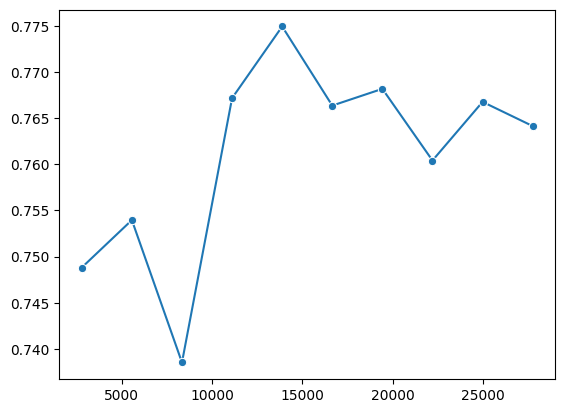

In [ ]:
plot_stats(subset_sizes_te, test_accuracies, test_losses)

In [ ]:
def save_metrics(filePath, variance_metrics, modelling_metrics):
  metrics = {'variance_metrics': variance_metrics, 'modelling_metrics': modelling_metrics}
  with open(filePath, "w") as outfile:
      json.dump(metrics, outfile)

In [ ]:
variance_metrics_te = {
    'full_set_var_sum': full_set_var_te.astype(float),
    'full_set_var_values': [val.astype(float) for val in explained_variance_ratio_te],
    'subsets_self_expl_vars': [val.astype(float) for val in self_expl_vars_te],
    'r2_values': r2_values_te,
    'subset_sizes': subset_sizes_te
}
modelling_metrics_te = {
    'subset_size': subset_sizes_te,
    'test_accuracies': test_accuracies,
    'test_losses': test_losses
}
save_metrics(f"/content/drive/MyDrive/CS567-ML/{DATASET_NAME}/run-metrics.json", variance_metrics_te, modelling_metrics_te)